In [25]:
import torch

from torchvision import transforms

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torchvision


from art.attacks.evasion import RobustDPatch
from art.attacks.evasion import DPatch
from art.estimators.object_detection import PyTorchFasterRCNN
from art.estimators.object_detection import PyTorchObjectDetector
from art.attacks.evasion import AdversarialPatchPyTorch

from utils import DrawBbox
from utils import load_trained_fasterrcnn_resnet50_fpn_v2

ConvertTensor=transforms.ToTensor()
DEVICE = torch.device('cpu')

from config_voc import pytorch_fname, KITTI_INSTANCE_CATEGORY_NAMES, NUM_CLASSES

# Detection using the trained faster RCNN

In [26]:
# model=load_trained_fasterrcnn_resnet50_fpn_v2(pytorch_fname,NUM_CLASSES)
# model.to(DEVICE).eval()

#Load the pretrained fasterRCNN model
model=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Create ART object detector
frcnn = PyTorchFasterRCNN(model,
        clip_values=(0, 255), attack_losses=["loss_classifier", "loss_box_reg", "loss_objectness", "loss_rpn_box_reg"],device_type="cpu"
    )

/home/aya/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/aya/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
COCO_INSTANCE_CATEGORY_NAMES = {0: u'__background__', 1: u'person', 2: u'bicycle',3: u'car', 4: u'motorcycle', 5: u'airplane', 6: u'bus', 7: u'train', 8: u'truck', 9: u'boat', 10: u'traffic light', 11: u'fire hydrant', 12: u'stop sign', 13: u'parking meter', 14: u'bench', 15: u'bird', 16: u'cat', 17: u'dog', 18: u'horse', 19: u'sheep', 20: u'cow', 21: u'elephant', 22: u'bear', 23: u'zebra', 24: u'giraffe', 25: u'backpack', 26: u'umbrella', 27: u'handbag', 28: u'tie', 29: u'suitcase', 30: u'frisbee', 31: u'skis', 32: u'snowboard', 33: u'sports ball', 34: u'kite', 35: u'baseball bat', 36: u'baseball glove', 37: u'skateboard', 38: u'surfboard', 39: u'tennis racket', 40: u'bottle', 41: u'wine glass', 42: u'cup', 43: u'fork', 44: u'knife', 45: u'spoon', 46: u'bowl', 47: u'banana', 48: u'apple', 49: u'sandwich', 50: u'orange', 51: u'broccoli', 52: u'carrot', 53: u'hot dog', 54: u'pizza', 55: u'donut', 56: u'cake', 57: u'chair', 58: u'couch', 59: u'potted plant', 60: u'bed', 61: u'dining table', 62: u'toilet', 63: u'tv', 64: u'laptop', 65: u'mouse', 66: u'remote', 67: u'keyboard', 68: u'cell phone', 69: u'microwave', 70: u'oven', 71: u'toaster', 72: u'sink', 73: u'refrigerator', 74: u'book', 75: u'clock', 76: u'vase', 77: u'scissors', 78: u'teddy bear', 79: u'hair drier', 80: u'toothbrush'}

In [28]:
# Read input image
input_img=cv2.imread("/home/aya/Desktop/Kitti_FasterRCNN/data/test/images/000074.png")
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB) # Convert to RGB
#input_img = cv2.resize(input_img, dsize=(input_img.shape[1], input_img.shape[0]), interpolation=cv2.INTER_CUBIC) resize images if you have multiple images
image = np.stack([input_img], axis=0).astype(np.float32)
print("image.shape:", image.shape)

image.shape: (1, 370, 1224, 3)


In [29]:
y= frcnn.predict(x=image) #RobustDpatch.generate() accept pred's values as arrays and not tensor

number of objects with 0.6 confidence: 11


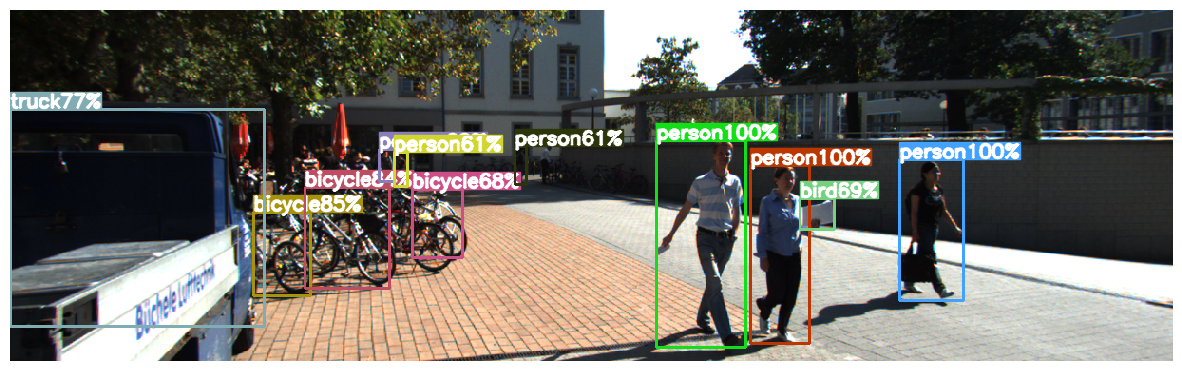

In [30]:
for i, y_i in enumerate(y):
        y[i]["boxes"] = torch.from_numpy(y_i["boxes"]).type(torch.float).to(frcnn._device)
        y[i]["labels"] = torch.from_numpy(y_i["labels"]).type(torch.int64).to(frcnn._device)
        y[i]["scores"] = torch.from_numpy(y_i["scores"]).to(frcnn._device)
#Draw bboxes
DrawBbox(input_img,y,COCO_INSTANCE_CATEGORY_NAMES,0.6)

# Generate an Adversarial Attack

In [31]:
def get_loss(frcnn, x, y):
    
    for i, y_i in enumerate(y):
        y[i]["boxes"] = torch.from_numpy(y_i["boxes"]).type(torch.float).to(frcnn._device)
        y[i]["labels"] = torch.from_numpy(y_i["labels"]).type(torch.int64).to(frcnn._device)
        y[i]["scores"] = torch.from_numpy(y_i["scores"]).to(frcnn._device)

    frcnn._model.train()
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    image_tensor_list = list()

    for i in range(x.shape[0]):
        if frcnn.clip_values is not None:
            img = transform(x[i] / frcnn.clip_values[1]).to(frcnn._device)
        else:
            img = transform(x[i]).to(frcnn._device)
        image_tensor_list.append(img)

    loss = frcnn._model(image_tensor_list, y)
    for loss_type in ["loss_classifier", "loss_box_reg", "loss_objectness", "loss_rpn_box_reg"]:
        loss[loss_type] = loss[loss_type].cpu().detach().numpy().item()
    return loss


def append_loss_history(loss_history, output):
    for loss in ["loss_classifier", "loss_box_reg", "loss_objectness", "loss_rpn_box_reg"]:
        loss_history[loss] += [output[loss]]
    return loss_history

In [32]:
# # Define attack parameters
# patch_shape = (64, 64,3)  # Adjust the patch shape as needed
# patch_location = (32, 32)  # Adjust the patch location as needed
# crop_range = (0, 0)  # Adjust the crop range as needed
# max_iter=1 #The number of optimization steps

# attack = DPatch(
#         frcnn,
#         patch_shape=patch_shape,
#         learning_rate=.45,
#         max_iter=10,
#         batch_size=16

#     )

In [33]:
attack = RobustDPatch(
    frcnn,
    patch_shape=(70, 70,3),
    patch_location=(40, 40),
    crop_range=[0,0],
    brightness_range=[1.0, 1.0],
    rotation_weights=[1, 0, 0, 0],
    sample_size=2,
    learning_rate=0.69,
    max_iter=10,
    batch_size=1,
    targeted=True,
    verbose=True,
)

In [34]:
pred = frcnn.predict(x=image) #RobustDpatch.generate() accept pred's values as arrays and not tensor
for i in range(len (pred[0]["scores"])):
    pred[0]["scores"][i]=0.
    pred[0]["labels"][i]=8
    pred[0]["boxes"][i]=[482.9539 , 172.3121 , 542.98627, 236.91972]

In [35]:
#External patch
ex_img = cv2.imread("/home/aya/Pictures/images1.jpeg")
print(ex_img.shape)
ex_img = cv2.cvtColor(ex_img, cv2.COLOR_BGR2RGB)  # Convert to RGB
ex_img = cv2.resize(ex_img, dsize=(80, 80), interpolation=cv2.INTER_CUBIC)

(290, 174, 3)


In [36]:
loss_history = {"loss_classifier": [], "loss_box_reg": [], "loss_objectness": [], "loss_rpn_box_reg": []}

best_x_patch=np.array(((1, 375, 1242, 3)))
best_loss=0.
for i in range(4):

    #APPLYING THE PATCH
    patch= attack.generate(x=image,y=pred)
    x_patch = attack.apply_patch(x=image)#,patch_external=ex_img
    loss = get_loss(frcnn, x_patch, frcnn.predict(x=image))
    print(loss)
    loss_history = append_loss_history(loss_history, loss)
    if(loss["loss_classifier"]>best_loss):
        print("save best patch at iteration",i)
        best_x_patch=x_patch
        best_loss=loss["loss_classifier"]


RobustDPatch iteration:   0%|          | 0/10 [00:00<?, ?it/s]

{'loss_classifier': 0.5119881629943848, 'loss_box_reg': 0.43524324893951416, 'loss_objectness': 0.03514976426959038, 'loss_rpn_box_reg': 0.12727133929729462}
save best patch at iteration 0


RobustDPatch iteration:   0%|          | 0/10 [00:00<?, ?it/s]

{'loss_classifier': 0.4914359152317047, 'loss_box_reg': 0.41183048486709595, 'loss_objectness': 0.04507382586598396, 'loss_rpn_box_reg': 0.17142871022224426}


RobustDPatch iteration:   0%|          | 0/10 [00:00<?, ?it/s]

{'loss_classifier': 0.5257363319396973, 'loss_box_reg': 0.4138765335083008, 'loss_objectness': 0.03659553825855255, 'loss_rpn_box_reg': 0.17410454154014587}
save best patch at iteration 2


RobustDPatch iteration:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

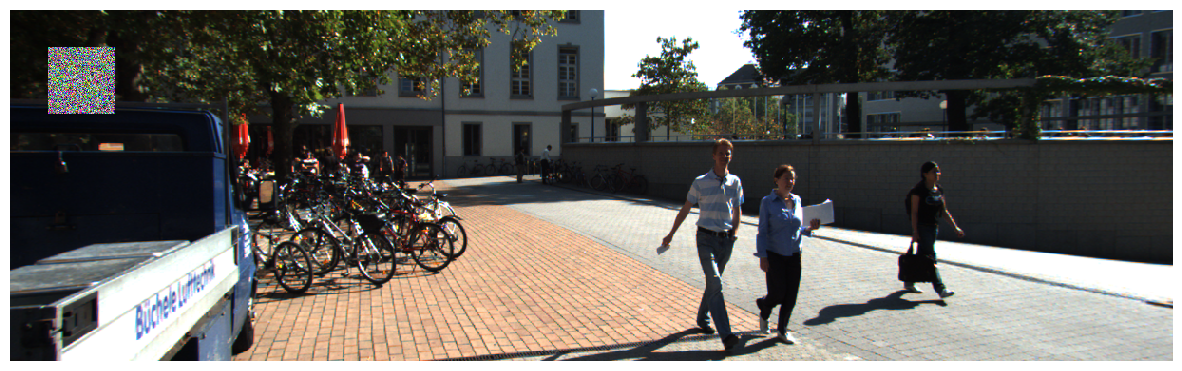

In [37]:
plt.figure(figsize=(15,15))
plt.axis("off")
plt.imshow(best_x_patch[0].astype(np.uint8), interpolation="nearest")

In [38]:
# save the image
img=best_x_patch[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.imwrite("photo.png", img)

True

In [39]:
img=cv2.imread("photo.png")
# Convert to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = np.stack([img], axis=0).astype(np.float32)

number of objects with 0.3 confidence: 23


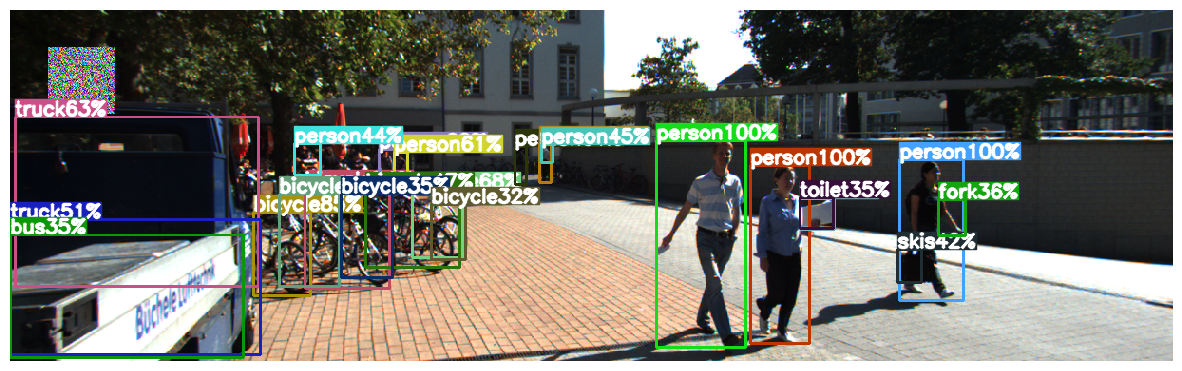

In [40]:
y=frcnn.predict(image)
for i, y_i in enumerate(y):
        y[i]["boxes"] = torch.from_numpy(y_i["boxes"]).type(torch.float).to(frcnn._device)
        y[i]["labels"] = torch.from_numpy(y_i["labels"]).type(torch.int64).to(frcnn._device)
        y[i]["scores"] = torch.from_numpy(y_i["scores"]).to(frcnn._device)
#Draw bboxes
DrawBbox(img,y,COCO_INSTANCE_CATEGORY_NAMES,0.3)